In [3]:
from random import sample, choice, choices, seed
from scipy.stats import wrapcauchy, levy_stable
import numpy as np
import os
import sys
import decimal
from tqdm import tqdm
from record_vis import RecordVis

# Custom map should be created with diff function in mind....
import matplotlib.pyplot as plt

In [12]:
len(map_.cells_to_search)

400

In [4]:
class Cell:
    def __init__(self, row, col, isboundary):
        self.visitors = []  # list of agents who have visited the cell
        self.notified = dict()  # list of agents who recognize the marking of that cell
        self.row = row
        self.col = col
        self.isboundary = isboundary

    def __repr__(self):
        return f"({self.row}, {self.col})"

class Map:
    ###### UPDATE WHATEVER IS DOING MAP CHECK STUFF ######
    def __init__(self, map_array): #map_size: int
        self.side_len = int(map_array.shape[0]) # Map array should be square
        self.map_size = self.side_len**2 # Map array should be square
        self.map = [[Cell(row=i, col=j, isboundary= map_array[i][j]) for j in range(self.side_len)] for i in range(self.side_len)]
        self.cells_to_search =[self.map[i][j]  for i in range(self.side_len) for j in range(self.side_len) if self.map[i][j].isboundary == False ]
        # self.map = np.array(self.map)
        self.visited_cells = 0

class Agent:
    def __init__(self, id_: int, v: float, seed_=None, fov="N/A"):
        self.id = id_
        self.v = v
        self.period = round(1 / v, 1)
        self.seed = seed_ if seed_ is not None else choice(range(sys.maxsize))
        self.search_time = 0
        self.fov = "N/A"


        # column where agents are indices and the value is the probability
        # that the agent will mark for them
        self.rel_row = None
    
    def __repr__(self):
        return f"Agent {self.id}"

    def place_in_map(self, map_):
        starting_cell = np.random.choice(map_.cells_to_search)
        return starting_cell.row, starting_cell.col
        
        

def get_agents(agent_class, num_agents, speeds, adj_matrix, fov):
    """
    Get a number of agents and agents speeds and care adjacency matrix.
    Update each agent's care dict according to adj matrix
    return list of agents
    """
    agents = [agent_class(id_=i, v=speeds[i], fov=fov, seed_=i + 10) for i in range(num_agents)]
    for agent in agents:
        agent.rel_row = adj_matrix[agent.id]
    return agents


In [5]:
### Agent Acts on Map - Define Random Walk Agent
class RandomWalkAgent(Agent):
    def __init__(self, id_: int, v: float, fov=12, seed_=None):
        super(RandomWalkAgent, self).__init__(id_, v, seed, fov=None)
        
        self.seed = seed_ if seed_ is not None else choice(range(sys.maxsize))
        self.fov = fov  # side length of observable square around the agent
        
        self.up, self.down, self.left, self.right = (-1, 0),  (1, 0), (0, -1), (0, 1)
        self.actions = [self.up,  self.down,  self.left, self.right]
        self.curr_pos = None
        self.prev_action = None

        # Levy Parameters
        self.alpha = .5
        self.beta = 0
        self.scale_to_var = 1/np.sqrt(2)
        self.levy_dist = levy_stable(self.alpha, self.beta, scale = self.scale_to_var)
        self.decision_wait_time = 0 # Relevent for Levy Walk

        # Turning Angle Parameters
        self.rho = .001 # 0 is completely fair 1 is biased to previous action
        self.wrap_dist = wrapcauchy(self.rho)
        self.curr_angle = np.random.random()*np.pi*2
        self.dest_comb = 20
        self.path_to_take = None
        self.path_taken_counter = 0

        
    def account_for_boundary(self, map_):
        row, col = self.curr_pos
        actions = self.actions.copy()

        if row == 0:
            actions[0] = actions[1]
        elif row == map_.side_len - 1:
            actions[1] = actions[0]
        if col == 0:
            actions[2] = actions[3]
        elif col == map_.side_len - 1:
            actions[3] = actions[2] 

        check_cells = [ (drow+row,dcol+col) for drow, dcol in [list(action) for action in actions]]

        for n, cell_ in enumerate(check_cells):
            m = (1,0,3,2) # Theres probably a better way to get opposite action
            if map_.map[cell_[0]][cell_[1]].isboundary:
                actions[n] = actions[m[n]]
    
        return actions

    def get_next_step(self, map_):
        """
        Randomly gets next step based on set of actions.
        Boundary conditions are reflective
        """
        prev_action = self.prev_action

        #Levy Walk each decision step continuos otherwise repeat last action
        if prev_action is None or self.decision_wait_time == 0:
            r = self.levy_dist.rvs()
            r = np.ceil(np.abs(r))
            self.decision_wait_time = int(r)

            r_angle = self.wrap_dist.rvs()
            self.curr_angle = (self.curr_angle + r_angle) % (2*np.pi)
            px = np.cos(self.curr_angle)
            py = np.sin(self.curr_angle)
            # print(px,py, r_angle)

            possible_actions = (int(-1*int(np.sign(py))),0), (0,int(np.sign(px)))
            px1 = abs(px)
            py1 = abs(py)
            # print(px1, py1, r_angle, self.curr_angle, self.decision_wait_time)
            self.path_to_take = [ possible_actions[i] for i in np.random.choice( [0,1], size = self.dest_comb, p = [py1**2, px1**2])]
        else:
            self.decision_wait_time -= 1
            

        actions_in_boundary = self.account_for_boundary(map_)

        desired_action = self.path_to_take[self.path_taken_counter]
        self.path_taken_counter = (1+self.path_taken_counter) % self.dest_comb
        
        if desired_action in actions_in_boundary:
            return desired_action
        else:
            # self.path_to_take = [( int(desired_action[0]*-1), int(desired_action[1]*-1)) if desired_action==x else x for x in self.path_to_take]
            if np.abs(desired_action[1]) == 1:
                dtheta  = self.curr_angle - np.pi/2 
                if dtheta>0:
                    self.curr_angle = np.pi/2 - dtheta
                else:
                    self.curr_angle = np.pi/2 + np.abs(dtheta)

            elif np.abs(desired_action[0]) == 1:
                dtheta  = self.curr_angle - np.pi 
                if dtheta>0:
                    self.curr_angle = np.pi - dtheta
                else:
                    self.curr_angle = np.pi + np.abs(dtheta)
            self.path_to_take = [ ( int(desired_action[0]*-1), int(desired_action[1]*-1)) if x == desired_action else x for x in self.path_to_take]
            # print("boundary hit", (self.curr_angle), np.cos(self.curr_angle), np.sin(self.curr_angle))
            # self.path_to_take = [ possible_actions[i] for i in np.random.choice( [0,1], size = self.dest_comb, p = [py1/(py1+px1),px1/(py1+px1)])]
            return ( int(desired_action[0]*-1) , int(desired_action[1]*-1) )

    def take_step(self, map_):
        # seed(self.seed)
        # prev_step = self.prev_pos
        # curr_step = self.curr_pos
        while True:
            if self.curr_pos is None:
                # This is the Initial step
                next_step = self.place_in_map(map_)
                row, col = next_step
            else:
                action = self.get_next_step(map_)
                # if action not in self.path_to_take:
                #     print(action, self.path_to_take,self.curr_angle)

                row, col = self.curr_pos[0] + action[0], self.curr_pos[1] + action[1] 
                self.prev_action = action
            
            self.curr_pos= (row, col)

            cell = map_.map[row][col]
            if not cell.notified.get(self.id):
                cell.visitors.append(self.id)
                update = True
            else:
                update = False
            # self.update_cell(cell)
            yield cell, update



In [ ]:
# class MultiAgentSearch:
#     def __init__(self, map_, agents, time_step=0.1, vis=False):
#         self.map = map_
#         self.agents = agents
#         self.time_step = time_step
#         self.vis = vis

#         self.period_dict = self.get_period_dict()
#         self.steps_generators = [agent.act(map_) for agent in agents]

#         self.record = {}

#     def get_period_dict(self):
#         period_dict = {}
#         # every rate has a list of agents with that rate (1/v)
#         for agent in self.agents:
#             try:
#                 period_dict[agent.period].append(agent.id)
#             except KeyError:
#                 period_dict[agent.period] = [agent.id]
#         return period_dict

#     def update_map(self, cell):
#         global FINISHED
#         # print(self.map.visited_cells)
#         if len(cell.visitors) == 1:
#             self.map.visited_cells += 1
#             if self.map.visited_cells == self.map.map_size:
#                 FINISHED = True

#     def divisible(self, num, den):
#         if num < den:
#             return False
#         return round(float(decimal.Decimal(str(num)) % decimal.Decimal(str(den))), 1) == 0

#     def search(self):
#         self.counter = self.time_step
#         while not FINISHED:
#             # get ids of agents who will provide cells. These are indices in the steps generators object
#             searchers_ids = []
#             for period, agents_ids in self.period_dict.items():
#                 if self.divisible(self.counter, period):
#                     searchers_ids.extend(agents_ids)

#             searchers_ids = sample(searchers_ids, len(searchers_ids))  # shuffle

#             for agent_id in searchers_ids:
#                 cell, update = next(self.steps_generators[agent_id])
#                 info = (agent_id, cell.row, cell.col)

#                 if self.vis:
#                     try:
#                         self.record[self.counter].append(info)
#                     except KeyError:
#                         self.record[self.counter] = [info]

#                 if update:
#                     self.update_map(cell)

#                 if FINISHED:
#                     if self.vis:
#                         self.vis_record()
#                         return

#             self.counter = round(self.counter + self.time_step, 1)

#     def vis_record(self):
#         RecordVis().vis_record(self.record, self.map.side_len, 'data/'+uuid.uuid1().hex)



In [6]:
map_size = 400
## Custom Map Will change to image input
test_map = np.zeros((int(map_size**0.5), int(map_size**0.5)), dtype= int)
# test_map[:,:] = 1
# test_map[7:,:] = 1


adj_matrix = np.load('networks/2/C.npy')

FINISHED = False
agent_class = RandomWalkAgent
num_agents = adj_matrix.shape[0]
fov = 1
speeds = np.ones(num_agents)
agent_list = get_agents(agent_class, num_agents, speeds, adj_matrix, fov)
map_ = Map(test_map)
step_generator = [agent.take_step(map_) for agent in agent_list]


In [7]:

record = {}
for counter in range(1,120):
    searchers_ids = sample([agent.id for agent in agent_list], len(agent_list))  # shuffle
    for agent_id in searchers_ids:
        ## Agent Taking Steps returns generator 
        cell, update = next(step_generator[agent_id])
        info = (agent_id, cell.row, cell.col)
        
        if counter not in record.keys():
            record[counter] = [info]
        else:
            record[counter].append(info)

In [8]:
RecordVis().vis_record(record, map_.side_len ,'data/'+'test_new_1' )

In [110]:
test, rot1, rot2 = 6.180320841448189, 7.751117168243086 %(2*np.pi), 4.609524514653293
print(np.sin([test, rot1, rot2]))
print(np.cos([test, rot1, rot2]))

[-0.10268316  0.99471411 -0.99471411]
[ 0.99471411  0.10268316 -0.10268316]


In [122]:
test = 3.14/4

print(test*180/np.pi)
dtheta  = test - np.pi 

if dtheta>0:
    new_angle = np.pi - dtheta
else:
    new_angle = np.pi + np.abs(dtheta)


print(new_angle*180/np.pi)


44.97718691776963
315.02281308223036


In [400]:
record

{1: [(1, 4, 4), (0, 6, 0)],
 2: [(1, 4, 5), (0, 5, 0)],
 3: [(1, 4, 6), (0, 4, 0)],
 4: [(1, 4, 7), (0, 4, 1)],
 5: [(0, 4, 2), (1, 5, 7)],
 6: [(0, 4, 3), (1, 6, 7)],
 7: [(0, 4, 4), (1, 6, 8)],
 8: [(0, 4, 5), (1, 6, 9)],
 9: [(1, 5, 9), (0, 4, 6)],
 10: [(0, 4, 7), (1, 4, 9)],
 11: [(0, 3, 7), (1, 4, 8)],
 12: [(1, 4, 7), (0, 4, 7)],
 13: [(1, 4, 8), (0, 4, 6)],
 14: [(0, 4, 5), (1, 4, 9)],
 15: [(1, 3, 9), (0, 4, 4)],
 16: [(1, 4, 9), (0, 5, 4)],
 17: [(0, 6, 4), (1, 5, 9)],
 18: [(0, 5, 4), (1, 5, 8)],
 19: [(0, 4, 4), (1, 5, 7)],
 20: [(1, 4, 7), (0, 3, 4)],
 21: [(1, 3, 7), (0, 3, 5)],
 22: [(1, 4, 7), (0, 3, 6)],
 23: [(1, 5, 7), (0, 3, 7)],
 24: [(0, 3, 8), (1, 5, 8)],
 25: [(1, 5, 9), (0, 3, 9)],
 26: [(0, 3, 8), (1, 6, 9)],
 27: [(0, 3, 7), (1, 5, 9)],
 28: [(1, 6, 9), (0, 3, 6)],
 29: [(1, 5, 9), (0, 3, 5)],
 30: [(0, 3, 4), (1, 4, 9)],
 31: [(1, 5, 9), (0, 3, 5)],
 32: [(1, 6, 9), (0, 3, 6)],
 33: [(0, 3, 5), (1, 5, 9)],
 34: [(1, 4, 9), (0, 3, 4)],
 35: [(0, 3, 3), (1, 3,

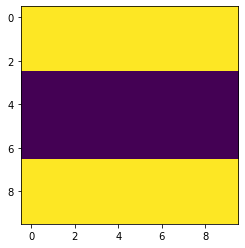

In [87]:
# Should be different function
# rand_map = np.random.randint(0,2,map_size).reshape((map_.side_len,map_.side_len))

img = plt.imshow(test_map)


# Junk

In [81]:
TEST_IF_CORRECT_YIELD = False

def generator_test():
    
    if TEST_IF_CORRECT_YIELD:
        test_string = "BANANAS"
    else:
        test_string ="this_sucks"

    yield test_string

In [85]:
next(generator_test())

'BANANAS'

In [84]:
TEST_IF_CORRECT_YIELD = True

In [1]:
from random import sample,choice, choices, seed
import numpy as np
import os
import sys
import decimal
# from tqdm import tqdm
from record_vis import RecordVis

In [2]:
import matplotlib.pyplot as plt

In [798]:
agents

[Agent 0, Agent 1, Agent 2]

In [809]:
next(act(agents[0], map_))

(9, 0) None


((0, 9), False)

In [822]:
np.array((3,2)) - np.array((4,2))

array([-1,  0])

In [820]:
np.array([3,2]) - np.array([4,2])

array([-1,  0])

In [799]:
def get_new_pos(self, step, prev_step):
    pactions = self.pactions.copy()

    rho = self.rho
    alpha = self.alpha
    angle = wrapcauchy.rvs(rho)

    step_size  = np.linspace(-25,25, num =50)
    step_dist = np.power(np.abs(step_size), -5*alpha)
    # step_dist = np.exp(-5*np.power(np.abs(step_size), alpha))
    r = choices(step_size, weights= step_dist)[0]

    self.x += r*np.cos(angle)
    self.y += r*np.sin(angle)

    if r<1.5:
        rel_x = np.cos(angle)
        rel_y = np.sin(angle)
        if np.abs(rel_x)>= np.abs(rel_y):
            return (0,int(rel_x))
        else:
            return [rel_y, rel_x]
    else:


def get_next_step(self, map_, step, prev_step):
    """
    Randomly gets next step based on set of actions.
    Boundary conditions are reflective
    """
    if prev_step == None:
        action = choice(self.get_actions(map_, step))
        return self.action_to_step(prev_step=step, action=action)

    p_action = get_new_pos(self, step, prev_step)
    actions = self.get_actions(map_, step)
    if p_action in actions:
        return self.action_to_step(prev_step=step, action=p_action)
    elif p_action*-1 in actions:
        return self.action_to_step(prev_step=step, action=p_action)


def act(self, map_):
    seed(self.seed)
    prev_step = None
    curr_step = None
    while True:
        if curr_step is None:
            next_step = (choice(range(map_.side_len)), choice(range(map_.side_len)))
        else:
            next_step = get_next_step(self, map_, curr_step, prev_step)

        row, col = next_step
        cell = map_.map[row][col]

        if not cell.notified.get(self.id):
            cell.visitors.append(self.id)
            update = True
        else:
            update = False
        self.update_cell(cell)
        prev_step = curr_step
        curr_step = next_step
        # self.update_cell_uniform(cell)
        yield cell, update

In [808]:
def act(self, map_):
    seed(self.seed)
    prev_step = None
    curr_step = None
    while True:
        if curr_step is None:
            next_step = (choice(range(map_.side_len)), choice(range(map_.side_len)))
        else:
            next_step = self.get_next_step(map_, curr_step, prev_step)

        row, col = next_step
        cell = map_.map[row][col]

        if not cell.notified.get(self.id):
            cell.visitors.append(self.id)
            update = True
        else:
            update = False
        self.update_cell(cell)
        prev_step = curr_step
        curr_step = next_step
        print(curr_step, prev_step)
        # self.update_cell_uniform(cell)
        yield cell, update

In [119]:
from scipy.stats import wrapcauchy
from scipy.stats import levy_stable
from scipy.stats import norm

In [13]:
alpha, beta = 1, 1
r = levy_stable.rvs(alpha, beta, size=10000)
r

array([ 0.93465077,  5.72114537, -0.35787379, ...,  0.17469321,
       -0.29789918,  0.12230384])

In [496]:
 wrapcauchy(.99).rvs()

6.126055589407912

In [42]:
x[2:-2]

array([0.12723612, 0.19069625, 0.25415639, 0.31761653, 0.38107667,
       0.44453681, 0.50799694, 0.57145708, 0.63491722, 0.69837736,
       0.76183749, 0.82529763, 0.88875777, 0.95221791, 1.01567804,
       1.07913818, 1.14259832, 1.20605846, 1.26951859, 1.33297873,
       1.39643887, 1.45989901, 1.52335914, 1.58681928, 1.65027942,
       1.71373956, 1.77719969, 1.84065983, 1.90411997, 1.96758011,
       2.03104025, 2.09450038, 2.15796052, 2.22142066, 2.2848808 ,
       2.34834093, 2.41180107, 2.47526121, 2.53872135, 2.60218148,
       2.66564162, 2.72910176, 2.7925619 , 2.85602203, 2.91948217,
       2.98294231, 3.04640245, 3.10986258, 3.17332272, 3.23678286,
       3.300243  , 3.36370314, 3.42716327, 3.49062341, 3.55408355,
       3.61754369, 3.68100382, 3.74446396, 3.8079241 , 3.87138424,
       3.93484437, 3.99830451, 4.06176465, 4.12522479, 4.18868492,
       4.25214506, 4.3156052 , 4.37906534, 4.44252547, 4.50598561,
       4.56944575, 4.63290589, 4.69636603, 4.75982616, 4.82328

In [102]:
(wrapcauchy(.99).rvs())/(2*np.pi)

0.999532099808853

In [87]:
6.28 - 5.299

0.9809999999999999

In [94]:
np.sum(wrapcauchy.pdf(x, c)[2:-2])/np.sum(wrapcauchy.pdf(x, c))

0.0001601888515169763

(0.0, 1.0)

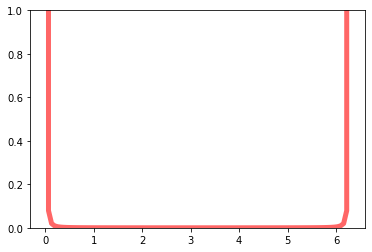

In [84]:
c= .999
x = np.linspace(wrapcauchy.ppf(0.01, c),
                wrapcauchy.ppf(0.99, c), 100)

fig, ax = plt.subplots(1, 1)

ax.plot(x, wrapcauchy.pdf(x, c),
       'r-', lw=5, alpha=0.6, label='wrapcauchy pdf')

plt.ylim(0,1)

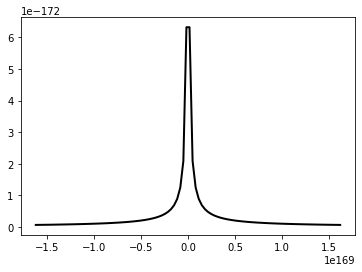

In [15]:

alpha, beta = .01, 0
x = np.linspace(levy_stable.ppf(0.01, alpha, beta),
                levy_stable.ppf(0.99, alpha, beta), 100)
rv = levy_stable(alpha, beta)
fig, ax = plt.subplots(1, 1)

ax.plot(x, rv.pdf(x), 'k-', lw=2, label='frozen pdf')

In [57]:
x[50:]

array([0.03323185, 0.09969554, 0.16615923, 0.23262292, 0.29908661,
       0.3655503 , 0.43201399, 0.49847768, 0.56494138, 0.63140507,
       0.69786876, 0.76433245, 0.83079614, 0.89725983, 0.96372352,
       1.03018721, 1.0966509 , 1.1631146 , 1.22957829, 1.29604198,
       1.36250567, 1.42896936, 1.49543305, 1.56189674, 1.62836043,
       1.69482413, 1.76128782, 1.82775151, 1.8942152 , 1.96067889,
       2.02714258, 2.09360627, 2.16006996, 2.22653366, 2.29299735,
       2.35946104, 2.42592473, 2.49238842, 2.55885211, 2.6253158 ,
       2.69177949, 2.75824318, 2.82470688, 2.89117057, 2.95763426,
       3.02409795, 3.09056164, 3.15702533, 3.22348902, 3.28995271])

In [144]:
rv.var()

4.0

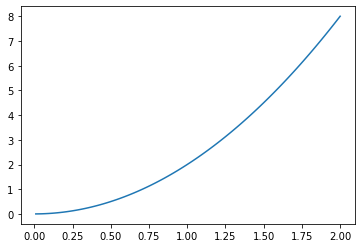

In [175]:

x = np.linspace(.01,2, num = 100)
y = [levy_stable(2.0,0, scale = i).var() for i in x]
y = np.array(y)

plt.plot(x,y)

In [182]:

rv = levy_stable(alpha, beta, scale = 1/np.sqrt(2))
rv.var()

0.9999999999999998

-0.1946239292117133


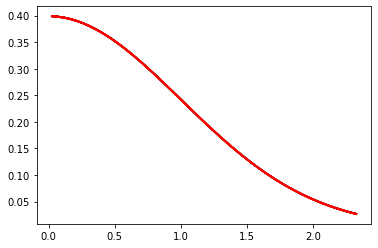

In [357]:
var = 1/np.sqrt(2)
alpha, beta = 2, 0
x = np.linspace(levy_stable.ppf(0.01, alpha, beta, scale = var),
                levy_stable.ppf(0.99, alpha, beta, scale = var), 100)
rv = levy_stable(alpha, beta, scale = var)
fig, ax = plt.subplots(1, 1)

ax.plot(np.abs(x), rv.pdf(x), 'k-', lw=2, label='frozen pdf')
[print(rv.rvs())]



x = np.linspace(norm.ppf(0.01),
                norm.ppf(0.99), 100)
rv = norm()
# fig, ax = plt.subplots(1, 1)

ax.plot(np.abs(x), rv.pdf(x), 'r-', lw=2, label='frozen pdf')
# plt.show()

plt.show()

In [360]:
rv = levy_stable(alpha, beta, scale = var)
rv.rvs()

-1.2367295530877958

In [642]:
rho = .01 # 0 is completely fair 1 is biased to previous action
wrap_dist = wrapcauchy(rho)
deg = 16
angle = np.random.randint(deg)

In [643]:
np.random.randint(17)

15

In [655]:
r = wrap_dist.rvs()
print(r)
print(r/(2*np.pi))
num = round(r*deg/(2*np.pi))
print(num%deg)
print(num/deg)

1.141226492501995
0.18163183746911835
3.0
0.1875


In [637]:
num

1.0

0.375


In [376]:
rv.rvs()

-0.6514030242775412

In [359]:
alpha, beta = 2.0, 0
rv = levy_stable(alpha, beta)

np.ceil(np.abs(rv.rvs()))

1.0

In [106]:
r = levy_stable.rvs(alpha, beta, size=10000)
r

array([ 0.7962869 , -0.48459516,  0.37097677, ..., -0.52344727,
       -0.73485273, -1.28321533])

In [118]:
len(r[r>2])/len(r)

0.1586

No handles with labels found to put in legend.


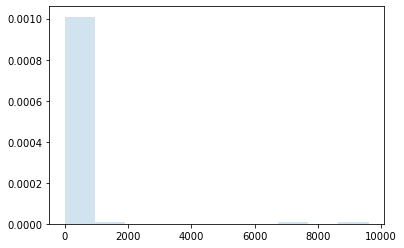

In [411]:
alpha, beta = .5, 0
var = 1/np.sqrt(2)

fig, ax = plt.subplots  (1, 1)
r = levy_stable.rvs(alpha, beta,scale = var, size=100)
r = np.ceil(np.abs(r))
ax.hist(r, density=True, histtype='stepfilled', alpha=0.2)
ax.legend(loc='best', frameon=False)
plt.show()

No handles with labels found to put in legend.


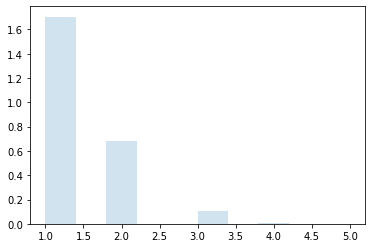

In [129]:

fig, ax = plt.subplots  (1, 1)
r = norm.rvs( size=100000)
r = np.ceil(np.abs(r))
ax.hist(r, density=True, histtype='stepfilled', alpha=0.2)
ax.legend(loc='best', frameon=False)
plt.show()

In [18]:
# Action:

step_lengths = power law distribution
angle = distribution of turning angles

SyntaxError: invalid syntax (Temp/ipykernel_13796/2774169162.py, line 3)

In [812]:
from scipy.stats import wrapcauchy

rho = .001# 0 is uniform, 1 is dirac, only for values 0<p<1
alpha = .01

angle = wrapcauchy.rvs(rho)

step_size  = np.linspace(-25,25, num =50)
step_dist = np.power(np.abs(step_size), -5*alpha)
# step_dist = np.exp(-5*np.power(np.abs(step_size), alpha))
r = choices(step_size, weights= step_dist)[0]

print('angle: ',angle, 'steps = ', r )

angle:  2.4100629348406057 steps =  3.571428571428573


In [814]:
x = r*np.cos(angle)
y = r*np.sin(angle)

print(np.ceil(x),np.ceil(y))

-2.0 3.0


In [817]:
a = choices([0,1,2])[0]
print(a)
[0,1,2].index(a)

2


2

In [796]:
x**2 + y**2

1.0

In [736]:
np.cos(angle)

0.9993239036418312

In [685]:
np.sin(angle)

-0.004735491033915596

In [718]:
l = []
for i in range(100):
    r = choices(step_size, weights= step_dist)[0]
    l.append(r)

len(set())

43

In [719]:
l

[-11.73469387755102,
 4.591836734693878,
 -20.918367346938776,
 15.816326530612244,
 -16.836734693877553,
 -11.73469387755102,
 -16.836734693877553,
 9.693877551020407,
 16.836734693877553,
 13.775510204081634,
 -21.93877551020408,
 -4.591836734693878,
 -6.632653061224488,
 -13.775510204081632,
 23.9795918367347,
 -22.959183673469386,
 -0.5102040816326507,
 12.755102040816325,
 25.0,
 -17.857142857142858,
 -1.5306122448979593,
 11.734693877551024,
 -22.959183673469386,
 -12.755102040816325,
 19.89795918367347,
 -17.857142857142858,
 -4.591836734693878,
 -9.693877551020408,
 -3.5714285714285694,
 -20.918367346938776,
 -23.979591836734695,
 25.0,
 12.755102040816325,
 11.734693877551024,
 -13.775510204081632,
 -11.73469387755102,
 2.5510204081632644,
 -12.755102040816325,
 -1.5306122448979593,
 21.93877551020408,
 -6.632653061224488,
 -7.653061224489797,
 25.0,
 5.612244897959183,
 -22.959183673469386,
 -4.591836734693878,
 7.653061224489797,
 -21.93877551020408,
 -7.653061224489797,
 9.

C:\Users\Ferna\AppData\Local\Temp/ipykernel_9956/3152831698.py:1: RuntimeWarning: divide by zero encountered in power
  step_dist = np.power(np.abs(step_size), -alpha)


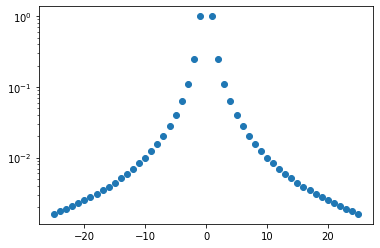

In [638]:
step_dist = np.power(np.abs(step_size), -alpha)


plt.scatter(step_size,step_dist)
plt.yscale('log')

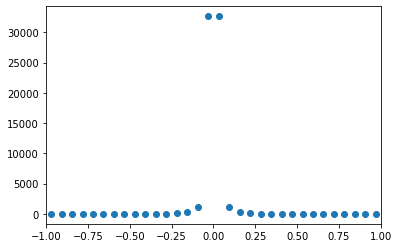

In [570]:
alpha = 2
N = 800
step_size  = np.linspace(-25,25, num = N)
step_dist = np.power(np.abs(step_size), -(alpha+1))

r = choices(step_size, weights= step_dist)
plt.scatter(step_size, step_dist)
plt.xlim(-1,1)
plt.show()

In [285]:

x = []

for y in range(10000):
    x.append(wrapcauchy.rvs(p))

(array([4.981e+03, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 3.000e+00, 3.000e+00, 5.012e+03]),
 array([5.44484762e-08, 6.28318552e-01, 1.25663705e+00, 1.88495555e+00,
        2.51327404e+00, 3.14159254e+00, 3.76991104e+00, 4.39822954e+00,
        5.02654803e+00, 5.65486653e+00, 6.28318503e+00]),
 <BarContainer object of 10 artists>)

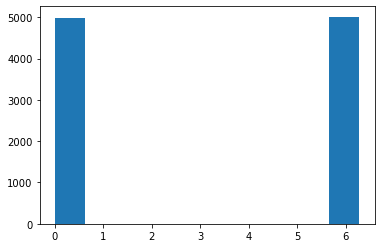

In [286]:
plt.hist(x)

In [221]:
def brownian_motion(N, T, h):
    """
    Simulates a Brownian motion
    :param int N : the number of discrete steps
    :param int T: the number of continuous time steps
    :param float h: the variance of the increments
    """   
    dt = 1. * T/N  # the normalizing constant
    random_increments = np.random.normal(0.0, 1.0 * h, N)*np.sqrt(dt)  # the epsilon values
    brownian_motion = np.cumsum(random_increments)  # calculate the brownian motion
    brownian_motion = np.insert(brownian_motion, 0, 0.0) # insert the initial condition
    
    return brownian_motion, random_increments

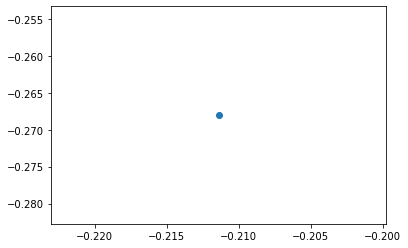

In [228]:
import random
import math

# radius of the circle
circle_r = 1
# center of the circle (x, y)
circle_x = 0
circle_y = 0

# random angle
alpha = 2 * math.pi * random.random()
# random radius
r = circle_r * math.sqrt(random.random())
# calculating coordinates
x = r * math.cos(alpha) + circle_x
y = r * math.sin(alpha) + circle_y

plt.scatter(x,y)
plt.show()

In [222]:
brownian_motion(10,1,1)

(array([ 0.        , -0.06001137, -0.16061413, -0.06914437, -0.4664969 ,
        -0.34649366, -0.61026095, -0.69496124, -0.95310169, -1.18594298,
        -0.61662279]),
 array([-0.06001137, -0.10060276,  0.09146976, -0.39735254,  0.12000325,
        -0.26376729, -0.08470029, -0.25814045, -0.23284129,  0.56932019]))

In [229]:
n_step = 1000
x0 = 0

w = np.ones(n_step)*x0
        
for i in range(1,n_step):
    # Sampling from the Normal distribution with probability 1/2
    yi = np.random.choice([1,-1])
    # Weiner process
    w[i] = w[i-1]+(yi/np.sqrt(n_step))

w

array([ 0.00000000e+00, -3.16227766e-02, -6.32455532e-02, -9.48683298e-02,
       -6.32455532e-02, -3.16227766e-02,  0.00000000e+00,  3.16227766e-02,
        6.32455532e-02,  9.48683298e-02,  1.26491106e-01,  9.48683298e-02,
        1.26491106e-01,  9.48683298e-02,  1.26491106e-01,  9.48683298e-02,
        6.32455532e-02,  9.48683298e-02,  6.32455532e-02,  3.16227766e-02,
        0.00000000e+00, -3.16227766e-02,  0.00000000e+00, -3.16227766e-02,
       -6.32455532e-02, -9.48683298e-02, -6.32455532e-02, -9.48683298e-02,
       -6.32455532e-02, -9.48683298e-02, -1.26491106e-01, -9.48683298e-02,
       -6.32455532e-02, -9.48683298e-02, -1.26491106e-01, -9.48683298e-02,
       -1.26491106e-01, -9.48683298e-02, -6.32455532e-02, -3.16227766e-02,
       -6.32455532e-02, -3.16227766e-02, -6.32455532e-02, -3.16227766e-02,
       -6.32455532e-02, -9.48683298e-02, -1.26491106e-01, -1.58113883e-01,
       -1.89736660e-01, -2.21359436e-01, -2.52982213e-01, -2.84604989e-01,
       -2.52982213e-01, -

In [207]:
w = np.ones(30)*2
w[]

array([2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.])

In [201]:
step_length

2.634683748087973

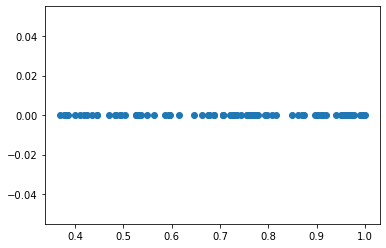

In [204]:


steps = []
for i in range(100):
    x = np.random.random()
    step_length = np.e**(- x**2)
    steps.append(step_length)


plt.scatter(steps, np.zeros(len(steps)))
plt.show()

In [186]:
choices([1,-1], weights = [1,0])[0]

1

In [744]:
desired_action = (0,1)

In [741]:
18.52 % 6.28

5.959999999999999

In [747]:
### Agent Acts on Map - Define Random Walk Agent

class RandomWalkAgent(Agent):
    def __init__(self, id_: int, v: float, fov=12, seed_=None):
        super(RandomWalkAgent, self).__init__(id_, v, seed, fov=None)
        
        self.seed = seed_ if seed_ is not None else choice(range(sys.maxsize))
        self.fov = fov  # side length of observable square around the agent
        
        self.up, self.down, self.left, self.right = (-1, 0),  (1, 0), (0, -1), (0, 1)
        self.actions = [self.up,  self.down,  self.left, self.right]
        self.curr_pos = None
        self.prev_action = None

        # Levy Parameters
        self.alpha = 2
        self.beta = 0
        self.scale_to_var = 1/np.sqrt(2)
        self.levy_dist = levy_stable(self.alpha, self.beta, scale = self.scale_to_var)
        self.decision_wait_time = 0 # Relevent for Levy Walk

        # Turning Angle Parameters
        self.rho = .01 # 0 is completely fair 1 is biased to previous action
        self.wrap_dist = wrapcauchy(self.rho)
        self.curr_angle = np.random.random()*np.pi*2
        self.dest_comb = 20
        self.path_to_take = None
        self.path_taken_counter = 0

        
    def account_for_boundary(self, map_):
        row, col = self.curr_pos
        actions = self.actions.copy()

        if row == 0:
            actions[0] = actions[1]
        elif row == map_.side_len - 1:
            actions[1] = actions[0]
        if col == 0:
            actions[2] = actions[3]
        elif col == map_.side_len - 1:
            actions[3] = actions[2] 

        check_cells = [ (drow+row,dcol+col) for drow, dcol in [list(action) for action in actions]]

        for n, cell_ in enumerate(check_cells):
            m = (1,0,3,2) # Theres probably a better way to get opposite action
            if map_.map[cell_[0]][cell_[1]].isboundary:
                actions[n] = actions[m[n]]
    
        return actions

    def get_next_step(self, map_):
        """
        Randomly gets next step based on set of actions.
        Boundary conditions are reflective
        """
        prev_action = self.prev_action

        #Levy Walk each decision step continuos otherwise repeat last action
        if prev_action is None or self.decision_wait_time ==0:
            r = self.levy_dist.rvs()
            r = np.ceil(np.abs(r))
            self.decision_wait_time = int(r)

            r_angle = self.wrap_dist.rvs()
            self.curr_angle = (r_angle +self.curr_angle) % (2*np.pi)
            px = np.cos(self.curr_angle)
            py = np.sin(self.curr_angle)

            possible_actions = (int(-1*(py)/np.abs(py)),0), (0,int(1*(px)/np.abs(px)))
            px1 = np.abs(px)
            py1 = np.abs(py)
            self.path_to_take = [ possible_actions[i] for i in np.random.choice( [0,1], size = self.dest_comb, p = [py1/(py1+px1),px1/(py1+px1)])]
        else:
            self.decision_wait_time -= 1
            self.path_taken_counter = (1+self.path_taken_counter) % self.dest_comb

        actions_in_boundary = self.account_for_boundary(map_)

        desired_action = self.path_to_take[self.path_taken_counter]

        if desired_action in actions_in_boundary:
            return desired_action
        else:
            self.path_to_take = [( int(desired_action[0]*-1), int(desired_action[1]*-1)) if desired_action==x else x for x in self.path_to_take]
            return ( int(desired_action[0]*-1), int(desired_action[1]*-1))

    def take_step(self, map_):
        # seed(self.seed)
        # prev_step = self.prev_pos
        # curr_step = self.curr_pos
        while True:
            if self.curr_pos is None:
                # This is the Initial step
                next_step = self.place_in_map(map_)
                row, col = next_step
            else:
                action = self.get_next_step(map_)
                
                row, col = self.curr_pos[0] + action[0], self.curr_pos[1] + action[1] 
                self.prev_action = action
            
            self.curr_pos= (row, col)

            cell = map_.map[row][col]
            if not cell.notified.get(self.id):
                cell.visitors.append(self.id)
                update = True
            else:
                update = False
            # self.update_cell(cell)
            yield cell, update



In [748]:
# Turning Angle Parameters
rho = .01 # 0 is completely fair 1 is biased to previous action
wrap_dist = wrapcauchy(rho)
curr_angle = np.random.random()*np.pi*2
num_dest_comb = 20
# print(curr_angle*360/(2*np.pi))


px = np.cos(curr_angle)
py = np.sin(curr_angle)

possible_actions = (int(-1*(py)/np.abs(py)),0), (0,int(1*(px)/np.abs(px)))
px1 = np.abs(px)
py1 = np.abs(py)
path_to_take = [ possible_actions[i] for i in np.random.choice( [0,1], size =num_dest_comb, p = [py1/(py1+px1),px1/(py1+px1)])]



path_to_take

[(0, -1),
 (-1, 0),
 (-1, 0),
 (0, -1),
 (0, -1),
 (-1, 0),
 (0, -1),
 (-1, 0),
 (0, -1),
 (0, -1),
 (0, -1),
 (0, -1),
 (0, -1),
 (0, -1),
 (0, -1),
 (0, -1),
 (0, -1),
 (0, -1),
 (0, -1),
 (-1, 0)]

In [ ]:
self.up, self.down, self.left, self.right = (-1, 0),  (1, 0), (0, -1), (0, 1)
self.actions = [self.up,  self.down,  self.left, self.right]

In [664]:
up, down, left, right = RandomWalkAgent(0, 1).actions

In [680]:
curr_angle

0.23689487787733501

[(0, 1),
 (-1, 0),
 (0, 1),
 (0, 1),
 (-1, 0),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (-1, 0),
 (-1, 0),
 (0, 1),
 (-1, 0),
 (-1, 0),
 (-1, 0),
 (-1, 0),
 (-1, 0),
 (0, 1),
 (0, 1)]

In [ ]:
np.shuffle( )

In [712]:
(3.0,5.0)

(3.0, 5.0)

In [708]:
(py)/np.abs(py)

1.0

In [703]:
px**2 + py**2

0.9999999999999999

In [671]:
angle_actions

[(1, 0), (0, 1)]

In [ ]:
curr_angle